In [40]:
%matplotlib inline
import sys
sys.path.append("../../")
import numpy as np
from simulator import AnalogCore
from simulator import CrossSimParameters
from applications.mvm_params import set_params
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(198)

## Application co-design with CrossSim

In this notebook, we will show some examples of how we can use CrossSim to evaluate the accuracy of analog processing-using-memory (PUM) on some applications. We will start with the Fourier transform application (Part 1) then evaluate on a neural network application (Part 2).

## Part 1: Discrete Fourier transform (DFT)

The DFT is an operation that is used ubiquitously for many applications. Here, we will demonstrate a 2D DFT which is a crucial component of many image processing workloads. It also has the nice advantage of allowing us to see the effects of simulated errors induced by analog PUM directly as visual artifacts in an image.

First, we will load the "Ichiro" image that will be used for this analysis.

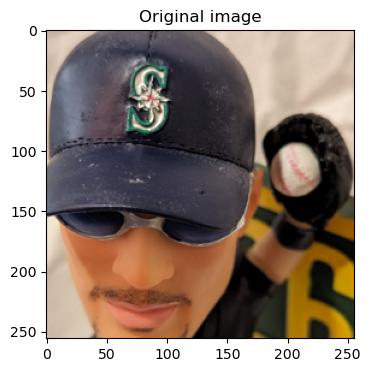

In [14]:
# Load image
N, N, Nch = 256, 256, 3
ichiro = Image.open('../../applications/dsp/example_images/ichiro.jpg').resize((N,N))
ichiro = np.array(ichiro).astype(np.float32) / 255

# Show image
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(ichiro)
ax.set_title("Original image")
plt.show()

For a square $N \times N$ image, the 2D DFT operation is defined by the following equation:

$Y_{j,k} = \sum \limits_{m=0}^{N-1} \sum \limits_{n=0}^{N-1} Y_{m,n} \exp{\left(-i\frac{2\pi}{N}kn\right)} \exp{\left(-i\frac{2\pi}{N}jm\right)}$

Using row-column decomposition, the 2D DFT can be written as two matrix-matrix multiplications applied on the input image:

$\mathbf{Y} = \mathbf{W}_N\mathbf{X}\mathbf{W}_N^T$

where $\mathbf{W}_N$ is the $N$-point DFT matrix, and $\mathbf{X}$ and $\mathbf{Y}$ are the 2D input and output. This can be written as MVMs wrapped inside two successive loops. After computing the 2D DFT, we can get back the original image by applying the 2D inverse DFT to the computed spectrum. The inverse DFT is evaluated using the same expression as above, but its matrix is the conjugate transpose: $\mathbf{W}_N^H$.

Let's first implement this using NumPy.

In [28]:
# First, create the matrices for the DFT and inverse DFT
W_dft = scipy.linalg.dft(N)
W_idft = np.matrix.getH(W_dft)

# Container for the 2D spectrum
spectrum = np.zeros(ichiro.shape, dtype=np.complex128)
# Container for the reconstruction
reconstruction = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):
    # DFT left multiply
    partial_dft = W_dft @ ichiro[:,:,ch]
    # DFT right multiply
    spectrum[:,:,ch] = partial_dft @ W_dft
    # IDFT left multiply
    partial_idft = W_idft @ spectrum[:,:,ch]
    # IDFT right multiply
    reconstruction[:,:,ch] = partial_idft @ W_idft

Now let's visualize the computed spectrum and the reconstructed image.

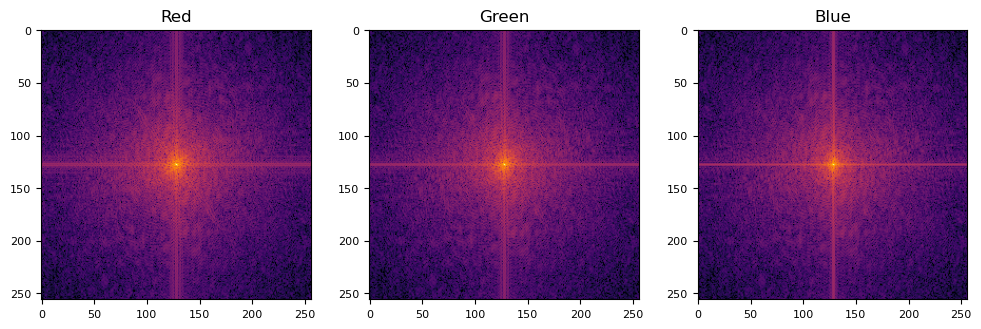

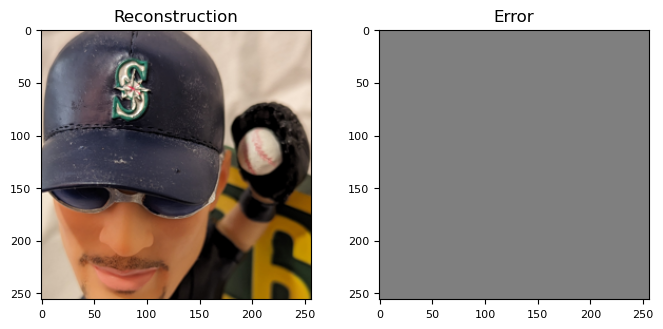

In [52]:
# Express each channel's spectrum as dBFS (decibels relative to full scale)

mag_spectrum = np.abs(spectrum)
maxVal = np.max(mag_spectrum)
dB_mag_red = np.fft.fftshift(20*np.log10((mag_spectrum[:,:,0].T + np.finfo(float).eps)/maxVal))
dB_mag_green = np.fft.fftshift(20*np.log10((mag_spectrum[:,:,1].T + np.finfo(float).eps)/maxVal))
dB_mag_blue = np.fft.fftshift(20*np.log10((mag_spectrum[:,:,2].T + np.finfo(float).eps)/maxVal))

# Normalize the reconstruction
reconstruction = np.abs(reconstruction)
reconstruction /= np.max(reconstruction)
error = reconstruction - ichiro + 0.5

# Show reconstructed image
fig,axes = plt.subplots(1,3,figsize=(12,3.5))
cmap = matplotlib.colormaps["inferno"]
axes[0].imshow(dB_mag_red, vmin=-100, vmax=0, cmap=cmap)
axes[0].set_title("Red")
axes[1].imshow(dB_mag_green, vmin=-100, vmax=0, cmap=cmap)
axes[1].set_title("Green")
axes[2].imshow(dB_mag_blue, vmin=-100, vmax=0, cmap=cmap)
axes[2].set_title("Blue")
[ax.tick_params(labelsize=8) for ax in axes]

fig2,axes2 = plt.subplots(1,2,figsize=(8,3.5))
axes2[0].imshow(reconstruction)
axes2[0].set_title("Reconstruction")
axes2[1].imshow(error)
axes2[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes2]
plt.show()


Next, we will simulate the analog PUM execution of these matrix multiplications using an AnalogCore. To begin with, we will assume that the analog hardware is perfectly ideal. This is done by instantiating a Parameters object and just using the default hardware parameters.

In [57]:
# Create a params object with default (ideal) analog PUM settings
ideal_params = CrossSimParameters()
ideal_params.core.complex_matrix = True

# Create an AnalogCore for both the DFT matrix and the inverse DFT matrix
xbar_dft = AnalogCore(W_dft, params=ideal_params)
xbar_idft = AnalogCore(W_idft, params=ideal_params)


Now that we have introduced a bit of error, let's look at the deviation between the result from CrossSim and NumPy (floating point):

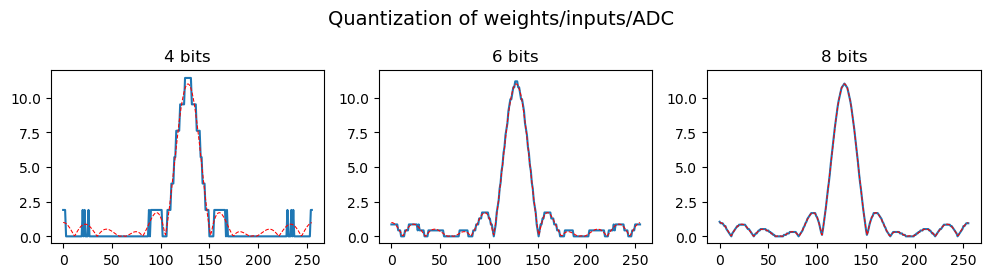

In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,2.25))
plt.subplots_adjust(hspace=0.3)
ax1.plot(np.fft.fftshift(np.abs(y_xbar_4b)))
ax2.plot(np.fft.fftshift(np.abs(y_xbar_6b)))
ax3.plot(np.fft.fftshift(np.abs(y_xbar_8b)))
for ax in (ax1,ax2,ax3):
    ax.plot(np.fft.fftshift(np.abs(y_np)),'--r',linewidth=0.75)
    ax.set_ylim([-0.5,12])
fig.suptitle("Quantization of weights/inputs/ADC",fontsize=14,y=1.15)
ax1.set_title("4 bits")
ax2.set_title("6 bits")
ax3.set_title("8 bits")
plt.show()

In this particular example, the most visibly obvious effect is the ADC quantization, especially in the 4-bit case.

### 2.2 Mapping to negative weights to analog arrays

How do we map a matrix containing negative weights to a crossbar array where the conductances are purely positive? There are two main ways to do this:

- __Differential (or balanced) cells__: each weight is encoded by the difference of two conductances
- __Offset subtraction__: each weight is encoded by one conductance with an offset, to be subtracted


<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/negative_numbers.png" width=500 />

Let's implement this in two separate AnalogCores, again using the real part of a DFT matrix as an example. We will also set the minimum and maximum resistance of the memory device to 1 k$\Omega$ and 1M$\Omega$, respectively.

In [4]:
# Define 64-point DFT matrix
N = 64
W_rdft = np.real(scipy.linalg.dft(N))

# Balanced core params
params_balanced = set_params(weight_bits = 8, 
                             wtmodel="BALANCED", 
                             Rmin = 1e3, 
                             Rmax = 1e6)

# Offset core params
params_offset = set_params(weight_bits = 8,
                           wtmodel="OFFSET",
                           Rmin = 1e3,
                           Rmax = 1e6)

# Create cores and program matrix
xbar_balanced = AnalogCore(W_rdft, params = params_balanced)
xbar_offset = AnalogCore(W_rdft, params = params_offset)

Here's what the numeric matrix looks like in NumPy:

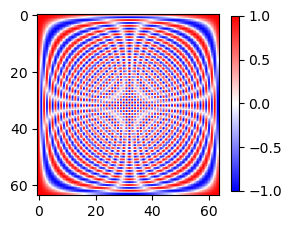

In [5]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
C1=ax.imshow(W_rdft,vmin=-1,vmax=1,cmap=plt.get_cmap('bwr'))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(C1, cax=cbar_ax)
plt.show()

Let's look under the hood at the crossbar of conductances that are used to store this matrix. Note here that the conductances are normalized to the max conductance and span the range from 0.001 to 1 since the resistance On/Off ratio is 1000.

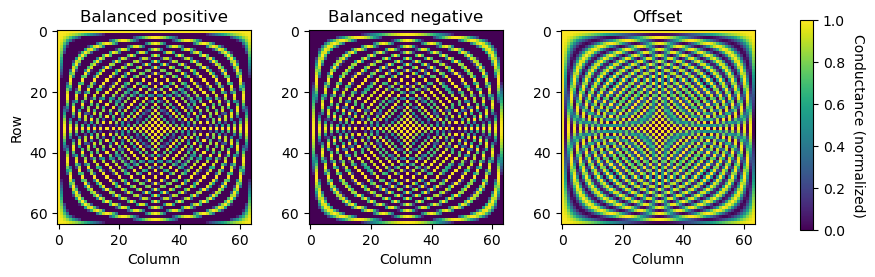

In [6]:
# Balanced core conductances
G_pos = xbar_balanced.cores[0][0].core_pos.matrix
G_neg = xbar_balanced.cores[0][0].core_neg.matrix

# Offset core conductances
G_offset = xbar_offset.cores[0][0].core.matrix

# Plot
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3))
plt.subplots_adjust(wspace=0.3)
C1=ax1.imshow(G_pos, vmin=0, vmax=1)
ax2.imshow(G_neg, vmin=0, vmax=1)
ax3.imshow(G_offset, vmin=0, vmax=1)
ax1.set_title("Balanced positive")
ax2.set_title("Balanced negative")
ax3.set_title("Offset")
ax1.set_ylabel("Row")
for ax in (ax1,ax2,ax3):
    ax.set_xlabel("Column")
    ax.set_aspect("equal")
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C1, cax=cbar_ax)
cbar.set_label("Conductance (normalized)",rotation=270,labelpad=15)
plt.show()

This should give some intuition on how these mapping settings work. In the following section we'll look at the difference in error sensitivity of these two mapping schemes.

### 2.3. Device programming error (generic)

Let's now add some random programming error onto the conductance values in the analog crossbar. An important consideration is how the expected amount of random error depends on the conductance state $G$. This characteristic is different for every device.

Here, we'll use one of the two generic device error models that are provided with CrossSim. In both models a normally distributed random error $\mathcal{N}(0,\sigma_G)$ is added to the conductance $G$:

- __State-independent (SI) error__: $\sigma_G = \alpha*G_\text{max}$
- __State-proportional (SP) error__: $\sigma_G = \alpha*G$

where $\alpha$ controls the overall magnitude of the error.

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/error_types.png" width=450 />

For this demo, we'll pick state-proportional error and look at how this error affects the computation differently for the balanced and offset cores above, this time using the full complex DFT matrix. There's a lot that can be said about the sensitivity to SI vs SP error of different algorithms and architectures, which can be analyzed in CrossSim, but for now we'll keep it simple.

In [7]:
# Create a DFT matrix
N_ft = 64
W_dft = scipy.linalg.dft(N_ft)

# Choose alpha to be 25%
alpha = 0.25

# Define a base set of params to use for all cores:
base_args = {'weight_bits' : 8, 'complex_matrix' : True, 'Rmin': 1e3, 'Rmax' : 1e6,
             'error_model' : 'generic', 'alpha_error' : alpha, 'proportional_error' : True}
params_balanced = set_params(wtmodel = "BALANCED", **base_args)
params_offset = set_params(wtmodel = "OFFSET", **base_args)

# Create cores and program matrix
xbar_balanced = AnalogCore(W_dft, params = params_balanced)
xbar_offset = AnalogCore(W_dft, params = params_offset)

Let's quantify the error in the matrix values (not the conductances) relative to the original matrix, for all four cases. We can call AnalogCore.get_matrix() to read out the numerical matrix that is being physically implemented by the arrays that make up the core. That means the effect of programming errors and other non-idealities will show up.

Mean absolute error in weight value
Balanced: 0.21637
  Offset: 0.34244


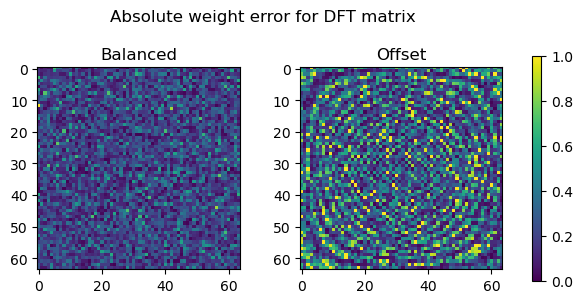

In [8]:
Werr_balanced = np.abs(W_dft - xbar_balanced.get_matrix())
Werr_offset = np.abs(W_dft - xbar_offset.get_matrix())

print("Mean absolute error in weight value")
print("===================================")
print("Balanced: {:.5f}".format(np.mean(Werr_balanced)))
print("  Offset: {:.5f}".format(np.mean(Werr_offset)))

# Visualize the distribution of errors across the matrix
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
plt.subplots_adjust(wspace=0.3)
C1=ax1.imshow(Werr_balanced, vmin=0, vmax=1)
ax2.imshow(Werr_offset, vmin=0, vmax=1)
fig.suptitle("Absolute weight error for DFT matrix", fontsize=12, y=1.025)
ax1.set_title("Balanced", fontsize=12)
ax2.set_title("Offset", fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.12, 0.015, 0.75])
cbar = fig.colorbar(C1, cax=cbar_ax)
plt.show()

The two cores have noticeably different error profiles with state-proportional error, and the balanced core has consistently lower mean errors. This difference is not just due to random differences in the generated error.
- The balanced core has low error where $|\mathbf{W}|$ is near zero
- The offset core has low error where $\text{Re}(\mathbf{W})$ or $\text{Im}(\mathbf{W})$ is close to -1 (the most negative value)

The balanced core also benefits from having two devices encode each real number as opposed to one. The random errors in the two devices are independent and can cancel, boosting the signal-to-noise ratio across the whole matrix relative to the case of the offset core.

Now let's look at how these device-level propagate to the algorithm level when these analog crossbars are used to compute a 2D DFT, using the same flower example from Part I.

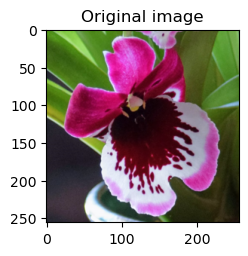

In [9]:
# Load image
N_ft1, N_ft2, Nch = 256, 256, 3
X_flower = Image.open('../applications/dsp/example_images/orchid.jpg').resize((N_ft1,N_ft2))
X_flower = np.array(X_flower).astype(np.float32) / 255

# Show image
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.imshow(X_flower)
ax.set_title("Original image")
plt.show()

Overall pixel-wise mean absolute error:
Balanced core error: 0.08355
  Offset core error: 0.14456


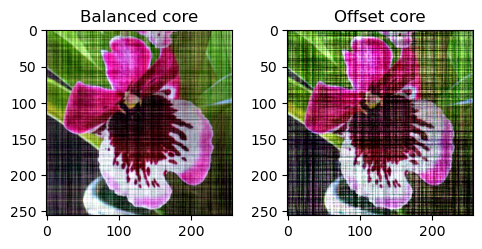

In [10]:
# DFT-256 matrix
W_dft = scipy.linalg.dft(N_ft1)
W_idft = np.matrix.getH(W_dft)

# Define a base set of params to use for all cores:
alpha = 0.15 # state-proportional error
base_args = {'weight_bits' : 8, 
             'complex_matrix' : True, 'complex_input' : True,
             'Rmin': 1e3, 'Rmax' : 1e6,
             'error_model' : 'generic', 'alpha_error' : alpha, 'proportional_error' : True}
params_balanced = set_params(wtmodel = "BALANCED", **base_args)
params_offset = set_params(wtmodel = "OFFSET", **base_args)

# Create cores and program matrices with random errors
xbar_balanced_dft = AnalogCore(W_dft, params = params_balanced)
xbar_balanced_idft = AnalogCore(W_idft, params = params_balanced)
xbar_offset_dft = AnalogCore(W_dft, params = params_offset)
xbar_offset_idft = AnalogCore(W_idft, params = params_offset)

# Perform image reconstruction
X_recon_balanced = np.zeros(X_flower.shape, dtype=np.complex128)
X_recon_offset = np.zeros(X_flower.shape, dtype=np.complex128)
for ch in range(Nch):
    # Balanced core
    Y_ch = (xbar_balanced_dft @ X_flower[:,:,ch]) @ xbar_balanced_dft
    X_recon_balanced[:,:,ch] = (xbar_balanced_idft @ Y_ch) @ xbar_balanced_idft    
    # Offset core
    Y_ch = (xbar_offset_dft @ X_flower[:,:,ch]) @ xbar_offset_dft
    X_recon_offset[:,:,ch] = (xbar_offset_idft @ Y_ch) @ xbar_offset_idft
    
# Normalize
X_recon_balanced = np.real(X_recon_balanced / (N_ft1*N_ft2)).clip(0,1)
X_recon_offset = np.real(X_recon_offset / (N_ft1*N_ft2)).clip(0,1)

# Overall error metric
err_balanced = np.mean(np.abs(X_recon_balanced - X_flower))
err_offset = np.mean(np.abs(X_recon_offset - X_flower))
print("Overall pixel-wise mean absolute error:")
print("===========================")
print("Balanced core error: {:.5f}".format(err_balanced))
print("  Offset core error: {:.5f}".format(err_offset))

# Show reconstructed image
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(5.5,2.5))
plt.subplots_adjust(wspace=0.3)
ax1.imshow(X_recon_balanced)
ax2.imshow(X_recon_offset)
ax1.set_title("Balanced core".format(alpha*100))
ax2.set_title("Offset core".format(alpha*100))
plt.show()

Consistent with the weight errors we looked at above, the DFT results has more artifacts in the case of offset core because of the larger MVM errors.

For a given amount of error, the signal-to-noise ratio also depends on the difference between the max and min conductance of the device. In the above, we assumed large conductance on/off ratio of 1000. What if the conductance ratio is much smaller, say 4? The conductance range available for the signal is now smaller, so we would expect the same programming error to have a larger effect on the accuracy.

Overall pixel-wise mean absolute error:
Balanced core error: 0.11186
  Offset core error: 0.19570


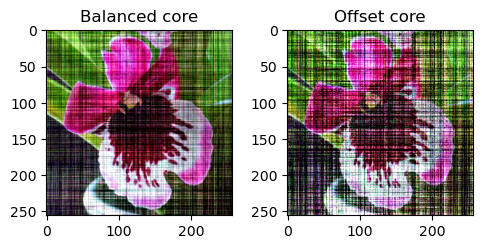

In [11]:
base_args = {'weight_bits' : 8, 'complex_matrix' : True, 'complex_input' : True,
             'Rmin': 1e3, 'Rmax' : 4e3, # On/Off ratio = 4
             'error_model' : 'generic', 'alpha_error' : alpha, 'proportional_error' : True}
params_balanced = set_params(wtmodel = "BALANCED", **base_args)
params_offset = set_params(wtmodel = "OFFSET", **base_args)

# Create cores and program matrices with random errors
xbar_balanced_dft = AnalogCore(W_dft, params = params_balanced)
xbar_balanced_idft = AnalogCore(W_idft, params = params_balanced)
xbar_offset_dft = AnalogCore(W_dft, params = params_offset)
xbar_offset_idft = AnalogCore(W_idft, params = params_offset)

# Perform image reconstruction
X_recon_balanced = np.zeros(X_flower.shape, dtype=np.complex128)
X_recon_offset = np.zeros(X_flower.shape, dtype=np.complex128)
for ch in range(Nch):
    # Balanced core
    Y_ch = (xbar_balanced_dft @ X_flower[:,:,ch]) @ xbar_balanced_dft
    X_recon_balanced[:,:,ch] = (xbar_balanced_idft @ Y_ch) @ xbar_balanced_idft    
    # Offset core
    Y_ch = (xbar_offset_dft @ X_flower[:,:,ch]) @ xbar_offset_dft
    X_recon_offset[:,:,ch] = (xbar_offset_idft @ Y_ch) @ xbar_offset_idft
    
# Normalize
X_recon_balanced = np.real(X_recon_balanced / (N_ft1*N_ft2)).clip(0,1)
X_recon_offset = np.real(X_recon_offset / (N_ft1*N_ft2)).clip(0,1)

# Overall error metric
err_balanced = np.mean(np.abs(X_recon_balanced - X_flower))
err_offset = np.mean(np.abs(X_recon_offset - X_flower))
print("Overall pixel-wise mean absolute error:")
print("===========================")
print("Balanced core error: {:.5f}".format(err_balanced))
print("  Offset core error: {:.5f}".format(err_offset))

# Show reconstructed image
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(5.5,2.5))
plt.subplots_adjust(wspace=0.3)
ax1.imshow(X_recon_balanced)
ax2.imshow(X_recon_offset)
ax1.set_title("Balanced core".format(alpha*100))
ax2.set_title("Offset core".format(alpha*100))
plt.show()

We have seen in the above example that are several mutually interacting factors that affect the accuracy of analog computation:
- Amount and state dependence of device programming error
- Device On/Off ratio
- Data mapping scheme for positive/negative numbers
- Value distribution of the weight matrix

### 2.4 Bit slicing

Another design choice related to algorithm-to-hardware mapping is related to the representation of bit precision. In the previous examples, we encoded 8-bit weights in the state(s) of one or a pair of devices, which were assumed to have at least 128 target-able memory states.

We could also choose to split the bit precision across multiple devices, with fewer bits encoded per device. This is called bit slicing. In the example below, we use balanced core with four slices to represent 8-bit weights.

Below is a pictorial representation of bit slicing:
<br />
<br />


<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/bit_slicing.png" width=500 />

Note that in the scheme above, because each slice is made up of a pair of 2-bit devices, it actually encodes three bits: two magnitude bits and a sign bit. Taking the four slices together, we actually have the range to represent 9-bit weights: eight magnitude bits and a sign bit.

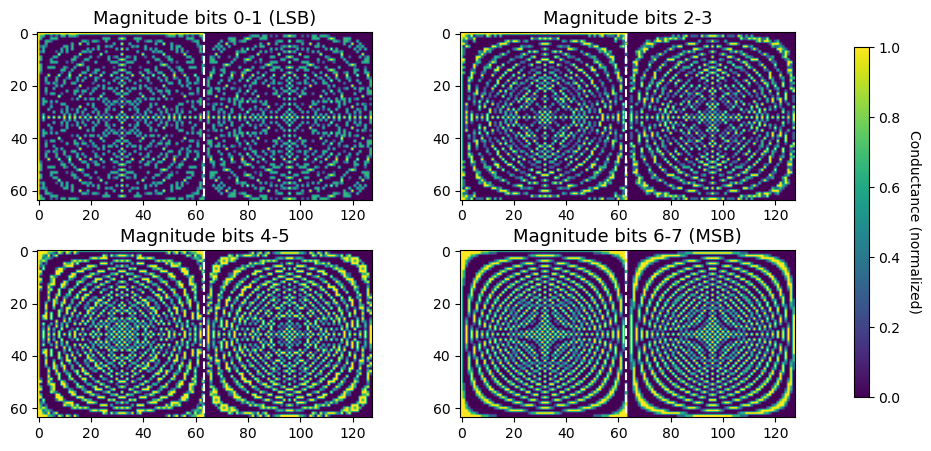

In [12]:
# Define DFT matrix
N = 64
W_rdft = np.real(scipy.linalg.dft(N))

# Balanced core params
Nslices = 4
params = set_params(weight_bits = 9,
                    Rmin = 1e3, Rmax = 1e6,
                    wtmodel = "BALANCED",
                    Nslices = Nslices)

# Create core and program matrix
xbar_balanced = AnalogCore(W_rdft, params = params)

# Get slice conductance matrices
G_slices = [None for i in range(Nslices)]
for i in range(Nslices):
    G_pos = xbar_balanced.cores[0][0].core_slices[i][0].matrix
    G_neg = xbar_balanced.cores[0][0].core_slices[i][1].matrix
    G_slices[i] = np.concatenate((G_pos, G_neg), axis=1)

Werr = np.abs(W_rdft - xbar_balanced.get_matrix())
    
# Plot
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(hspace=0.3)
C1=ax1.imshow(G_slices[0], vmin=0, vmax=1)
ax2.imshow(G_slices[1], vmin=0, vmax=1)
ax3.imshow(G_slices[2], vmin=0, vmax=1)
ax4.imshow(G_slices[3], vmin=0, vmax=1)
ax1.set_title("Magnitude bits 0-1 (LSB)",fontsize=13)
ax2.set_title("Magnitude bits 2-3",fontsize=13)
ax3.set_title("Magnitude bits 4-5",fontsize=13)
ax4.set_title("Magnitude bits 6-7 (MSB)",fontsize=13)
for ax in (ax1,ax2,ax3,ax4):
    ax.plot([N-1,N-1],[0,N-1],'--',color='white')
    ax.set_aspect("equal")
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C1, cax=cbar_ax)
cbar.set_label("Conductance (normalized)",rotation=270,labelpad=15)
plt.show()

Let's see how the accuracy of the algorithm changes when we use bit slicing.

Overall pixel-wise mean absolute error:
   One slice: 0.08336
 Four slices: 0.06327


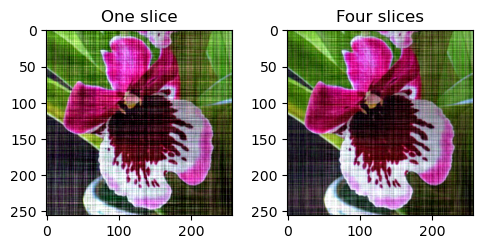

In [13]:
# DFT-256 matrix
N_ft = 256
W_dft = scipy.linalg.dft(N_ft)
W_idft = np.matrix.getH(W_dft)

# Define a base set of params to use for all cores:
alpha = 0.15 # state-proportional error
base_args = {'weight_bits' : 9, 'complex_matrix' : True, 'complex_input' : True,
             'wtmodel' : 'BALANCED', 'Rmin': 1e3, 'Rmax' : 1e6,
             'error_model' : 'generic', 'alpha_error' : alpha, 'proportional_error' : True}
params_1S = set_params(Nslices = 1, **base_args)
params_4S = set_params(Nslices = 4, **base_args)

# Create cores and program matrices
xbar_dft_1S = AnalogCore(W_dft, params = params_1S)
xbar_idft_1S = AnalogCore(W_idft, params = params_1S)
xbar_dft_4S = AnalogCore(W_dft, params = params_4S)
xbar_idft_4S = AnalogCore(W_idft, params = params_4S)

# Perform image reconstruction
X_recon_1S = np.zeros(X_flower.shape, dtype=np.complex128)
X_recon_4S = np.zeros(X_flower.shape, dtype=np.complex128)
for ch in range(Nch):
    # One slice
    Y_ch = (xbar_dft_1S @ X_flower[:,:,ch]) @ xbar_dft_1S
    X_recon_1S[:,:,ch] = (xbar_idft_1S @ Y_ch) @ xbar_idft_1S    
    # Four slices
    Y_ch = (xbar_dft_4S @ X_flower[:,:,ch]) @ xbar_dft_4S
    X_recon_4S[:,:,ch] = (xbar_idft_4S @ Y_ch) @ xbar_idft_4S    
X_recon_1S = np.real(X_recon_1S / (N_ft1*N_ft2)).clip(0,1)
X_recon_4S = np.real(X_recon_4S / (N_ft1*N_ft2)).clip(0,1)

# Overall error metric
err_1S = np.mean(np.abs(X_recon_1S - X_flower))
err_4S = np.mean(np.abs(X_recon_4S - X_flower))
print("Overall pixel-wise mean absolute error:")
print("===========================")
print("   One slice: {:.5f}".format(err_1S))
print(" Four slices: {:.5f}".format(err_4S))

# Show reconstructed image
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(5.5,2.5))
plt.subplots_adjust(wspace=0.3)
ax1.imshow(X_recon_1S)
ax2.imshow(X_recon_4S)
ax1.set_title("One slice".format(alpha*100))
ax2.set_title("Four slices".format(alpha*100))
plt.show()

In this example, the analog computation does demonstrably improve with bit slicing, though the benefit is somewhat marginal. Considering that bit slicing comes at a significant area and energy cost, it is not completely obvious whether bit slicing is worth it here.

There's a lot more that can be said for why the improvement here is relatively small, and about how some other applications can benefit more from it. See, for example, the discussion in Section V of Ref. [1].

### 2.5 Parasitic resistance and matrix splitting

Besides device errors, another major source of errors in analog IMC is the parasitic resistance of the metal wires. To simulate the effect of array parasitics, CrossSim internally performs a fast circuit simulation on every MVM. Let's see how this affects a simple 1D DFT example (real part only).
<br />
<br />

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/parasitics.png" width=220 />

In this example, the memory device will have a resistance ranging from 1 k$\Omega$ to 1 M$\Omega$.

Reduced MVM convergence parameter to: 0.81353


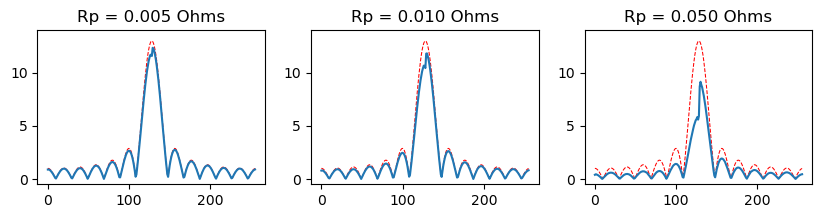

In [14]:
# DFT matrix
N_ft1 = 256
W = np.real(scipy.linalg.dft(N_ft1))

# Rectangular pulse input
x = np.zeros(N_ft1)
x[(N_ft1//2-6):(N_ft1//2+7)] = 1

# Set parameters for core with and without parasitic resistance
Rp1 = 5e-3 # 0.005 ohms
Rp2 = 1e-2 # 0.010 ohms
Rp3 = 5e-2 # 0.050 ohms
base_args = {'input_range' : (0,1), 'wtmodel' : 'BALANCED', 'gate_input' : False, 
             'Rmin': 1e3, 'Rmax' : 1e6}
params_ideal = set_params(**base_args)
params_par1 = set_params(Rp_row = Rp1, Rp_col = Rp1, **base_args)
params_par2 = set_params(Rp_row = Rp2, Rp_col = Rp2, **base_args)
params_par3 = set_params(Rp_row = Rp3, Rp_col = Rp3, **base_args)

# Create an AnalogCore and program matrix
xbar_ideal = AnalogCore(W, params=params_ideal)
xbar_par1 = AnalogCore(W, params=params_par1)
xbar_par2 = AnalogCore(W, params=params_par2)
xbar_par3 = AnalogCore(W, params=params_par3)

# Use the AnalogCore like a NumPy array
y_ideal = xbar_ideal @ x
y_par1 = xbar_par1 @ x
y_par2 = xbar_par2 @ x
y_par3 = xbar_par3 @ x

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,2))
for ax in (ax1,ax2,ax3):
    ax.plot(np.fft.fftshift(np.abs(y_ideal)),'--r', linewidth=0.75)
    ax.set_ylim([-0.5,14])
ax1.plot(np.fft.fftshift(np.abs(y_par1)))
ax2.plot(np.fft.fftshift(np.abs(y_par2)))
ax3.plot(np.fft.fftshift(np.abs(y_par3)))
ax1.set_title("Rp = {:.3f} Ohms".format(Rp1))
ax2.set_title("Rp = {:.3f} Ohms".format(Rp2))
ax3.set_title("Rp = {:.3f} Ohms".format(Rp3))
plt.show()


This MVM is very sensitive to parasitic resistance. Although the memory devices have a resistance in the range from 1 k$\Omega$ to 1 M$\Omega$, the output is heavily distorted when the unit cell wire resistance is as small as 0.05$\Omega$!

This is because the matrix is somewhat large: 256$\times$256. By default, CrossSim will allocate an array that fits the whole matrix. This means large currents are flowing along the rows and/or columns. In this example, the voltage drops along the rows are the big problem since only a few rows along a column are activated. So we expect that splitting up the matrix into multiple arrays, partitioned along the column dimension to help a lot. Meanwhile, splitting by rows would help comparatively little.

In CrossSim we can easily partition a weight matrix across multiple physical arrays by setting a limit on the max number of rows and/or columns for the physical array. Let's see if reducing the array size reduces the effect of parasitic resistance.

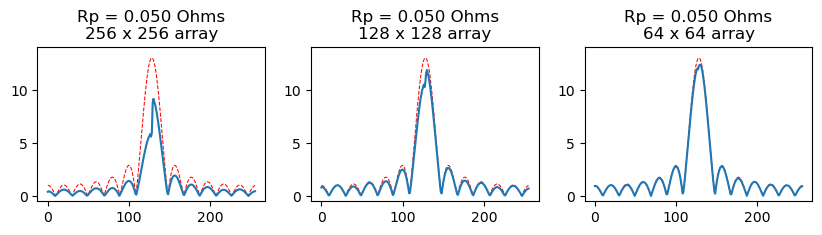

In [15]:
# Set parameters for core with and without parasitic resistance
Rp = 5e-2
base_args = {'input_range' : (0,1), 'wtmodel' : 'BALANCED', 'gate_input' : False, 
            'Rmin': 1e3, 'Rmax' : 1e6, 'Rp_row' : Rp, 'Rp_col' : Rp}
params_128 = set_params(NcolsMax = 128, NrowsMax = 128, **base_args)
params_64 = set_params(NcolsMax = 64, NrowsMax = 64, **base_args)

# Create an AnalogCore and program matrix
xbar_128 = AnalogCore(W, params=[params_128]*4)
xbar_64 = AnalogCore(W, params=[params_64]*16)

# Use the AnalogCore like a NumPy array
y_128 = xbar_128 @ x
y_64 = xbar_64 @ x

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,2))
for ax in (ax1,ax2,ax3):
    ax.plot(np.fft.fftshift(np.abs(y_ideal)),'--r', linewidth=0.75)
    ax.set_ylim([-0.5,14])
ax1.plot(np.fft.fftshift(np.abs(y_par3)))
ax2.plot(np.fft.fftshift(np.abs(y_128)))
ax3.plot(np.fft.fftshift(np.abs(y_64)))
ax1.set_title("Rp = {:.3f} Ohms\n256 x 256 array".format(Rp))
ax2.set_title("Rp = {:.3f} Ohms\n128 x 128 array".format(Rp))
ax3.set_title("Rp = {:.3f} Ohms\n64 x 64 array".format(Rp))
plt.show()

Indeed, it looks like reducing the array size from 256$\times$256 to 64$\times$64 almost fully mitigates the effect of parasitic resistance, even though the 

### 2.6 Saving and loading core and simulation settings

The CrossSim Parameters object has a JSON interface that makes it easy to port the same core or simulation settings to a different script, codebase or machine. This also makes it easy to reproduce prior simulation results (up to the random seed).

Here, we show demonstrate the JSON interface by exporting the parameters we created in Section 2.5 for running a parasitic resistance simulation with a 64$\times$64 array. Then, we create a fresh CrossSimParameters object and load the parameters that are saved in the JSON file, and re-run the simulation.

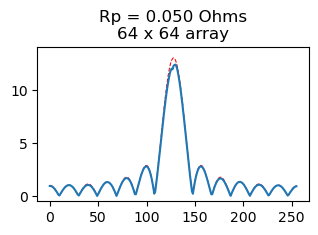

In [16]:
# Save the last used parameters to a JSON file
params_64.to_json("./params_64.json")

# Create a new parameters object
params_new = CrossSimParameters()

# Load the parameters from the JSON file
params_new = params_new.from_json("./params_64.json")

# Re-run the 64x64 parasitic resistance simulation with the new parameters object
xbar_64 = AnalogCore(W, params=[params_new]*16)
y_64 = xbar_64 @ x

fig, ax1 = plt.subplots(1,1,figsize=(3.5,2))
ax1.plot(np.fft.fftshift(np.abs(y_ideal)),'--r', linewidth=0.75)
ax1.set_ylim([-0.5,14])
ax1.plot(np.fft.fftshift(np.abs(y_64)))
ax1.set_title("Rp = {:.3f} Ohms\n64 x 64 array".format(Rp))
plt.show()

The results are identical to the output of the last code cell.

### References

[1] T. P. Xiao, B. Feinberg, C. H. Bennett, V. Prabhakar, P. Saxena, V. Agrawal, S. Agarwal, and M. J. Marinella, "On the accuracy of analog neural network inference accelerators," _IEEE Circuits and Systems Magazine_, 22(4), pp. 26-48, 2022.